## Goal

To produce datapoints in 7d space by building 7-spheres in all orthants (2 concentric spheres of radii, say, 1 and 2 in all orthants,
centered at say, a distance of 4 from all axes) in a non-uniform fashion, i.e., some orthants would have fewer points and some more points
(say, 25% of the orthants have fewer points, perhaps ~25 points in most orthants and ~4 points in the rarer orthants).

We wish to determine the performance of a neural network for different orthants - does it perform equally well or similar in all orthants,
determining that there is symmetry present in the data? Or does it fail to do so, doing well only in the orthants with more data? We use a
validation set of say, 4 points per orthant to quantify each orthant's performance.

## Data

### Defining constants

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
SIGNS = [-1., 1.] 

ORTHANTS = torch.stack(
    [torch.tensor([s1, s2, s3, s4, s5, s6, s7])
    for s1 in SIGNS
    for s2 in SIGNS
    for s3 in SIGNS
    for s4 in SIGNS
    for s5 in SIGNS
    for s6 in SIGNS
    for s7 in SIGNS])   # Representing each orthant as the sign of each of its 7 coordinates/wrt each of its 7 axes
ORTHANTS.shape

torch.Size([128, 7])

In [64]:
LOW_COUNT = 4   # Average no. of points in a "rare" orthant
HIGH_COUNT = 25 # Average no. of points in a "typical" orthant
LOW_SPREAD = 2  # Allowed unidirectional deviation for no. of points in a "rare" orthant (i.e., 2 to 6 points)
HIGH_SPREAD = 8 # Allowed unidirectional deviation for no. of points in a "typical" orthant (i.e., 17 to 33 points)
VAL_COUNT = 4   # Validation data points per orthant
TEST_COUNT = 10 # Test data points per orthant, for final pattern
LOW_FRAC = 0.25 # Number of "rare" orthants

In [12]:
HIGH_ORTHANTS, LOW_ORTHANTS = train_test_split(ORTHANTS, test_size=LOW_FRAC)
# Randomly choosing the "rare" orthants
HIGH_ORTHANTS.shape, LOW_ORTHANTS.shape

(torch.Size([96, 7]), torch.Size([32, 7]))

In [14]:
CENTRE = 4 * torch.ones(7)
# The centre of the 7-spheres, without orthant-specificity, which can be included using ORTHANTS
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [15]:
LOW_RADIUS = 1. # Radius of the inner sphere (say, label 0) in each orthant
HIGH_RADIUS = 2.    # Radius of the outer sphere (say, label 1) in each orthant

### Data generation

Now, we describe a 7-sphere using the standard notation. <br>
Say, it is centered at $C = (C_1, C_2, ..., C_7)$ and has radius $r$. Each point can be described with the help of 6 angles, <br>
$\phi_1$, $\phi_2$, $\phi_3$, $\phi_4$, $\phi_5$, and $\phi_6$, where $\phi_6 \in [0, 2\pi)$ and $\phi_1, ..., \phi_5 \in [0, \pi]$ <br>
Any point $x = (x_1, x_2, ..., x_7)$ on the sphere can be described as follows: <br>
$x_1 = C_1 + r\cos(\phi_1)$ <br>
$x_2 = C_2 + r\sin(\phi_1)\cos(\phi_2)$ <br>
$x_3 = C_3 + r\sin(\phi_1)\sin(\phi_2)\cos(\phi_3)$ <br>
$x_4 = C_4 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\cos(\phi_4)$ <br>
$x_5 = C_5 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\cos(\phi_5)$ <br>
$x_6 = C_6 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\cos(\phi_6)$ <br>
$x_7 = C_7 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\sin(\phi_6)$
<br>

Hence, each datapoint will be sampled by randomly generating the 6 angles from appropriate uniform distributions and 
performing the mentioned transformation

In [16]:
def generate_point(
    radius: float,
    orthant: torch.Tensor
) -> torch.Tensor:
    """
    Generates a point on a 7-sphere of centre orthant * CENTRE (global) with radius radius, where
    orthant denotes the signs wrt all 7 axes

    Args:
        radius (float): radius of the 7-sphere
        orthant (torch.Tensor): signs wrt the 7 axes for the resulting point, of shape (7,)
    
    Returns:
        x (torch.Tensor): a point on the specified sphere, of shape (7,)
    
    Example usage:
    >>> generate_point(2, tensor([1., 1., 1., 1., 1., 1., 1.]))
    tensor([2., 4., 4., 4., 4., 4., 4.])
    """
    phi = torch.rand((6,)) * torch.pi
    phi[5] *= 2
    diff_unit = torch.tensor([
        torch.cos(phi[0]),
        torch.sin(phi[0])*torch.cos(phi[1]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.cos(phi[2]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.cos(phi[3]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.cos(phi[4]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.sin(phi[4])*torch.cos(phi[5]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.sin(phi[4])*torch.sin(phi[5])
    ])
    return torch.mul(CENTRE + radius * diff_unit, orthant)
    

In [30]:
# Testing correctness

random_point = generate_point(2, ORTHANTS[0])
random_point, ((random_point - ORTHANTS[0]*CENTRE)**2).sum().sqrt()

(tensor([-5.0321, -2.6003, -4.9444, -3.9641, -3.8374, -4.2178, -4.0930]),
 tensor(2.0000))

#### Train data

In [37]:
X_train_low_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * LOW_SPREAD + LOW_COUNT))
    ]) for orthant in LOW_ORTHANTS
])
X_train_low_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * LOW_SPREAD + LOW_COUNT))
    ]) for orthant in LOW_ORTHANTS
])
X_train_high_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * HIGH_SPREAD + HIGH_COUNT))
    ]) for orthant in HIGH_ORTHANTS
])
X_train_high_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * HIGH_SPREAD + HIGH_COUNT))
    ]) for orthant in HIGH_ORTHANTS
])
X_train_low_0.shape, X_train_low_1.shape, X_train_high_0.shape, X_train_high_1.shape

(torch.Size([108, 7]),
 torch.Size([116, 7]),
 torch.Size([2297, 7]),
 torch.Size([2377, 7]))

In [39]:
Y_train_low_0 = torch.zeros(len(X_train_low_0), 1)
Y_train_low_1 = torch.ones(len(X_train_low_1), 1)
Y_train_high_0 = torch.zeros(len(X_train_high_0), 1)
Y_train_high_1 = torch.ones(len(X_train_high_1), 1)
Y_train_low_0.shape, Y_train_low_1.shape, Y_train_high_0.shape, Y_train_high_1.shape

(torch.Size([108, 1]),
 torch.Size([116, 1]),
 torch.Size([2297, 1]),
 torch.Size([2377, 1]))

In [40]:
X_train = torch.cat([
    X_train_low_0,
    X_train_low_1,
    X_train_high_0,
    X_train_high_1
])
Y_train = torch.cat([
    Y_train_low_0,
    Y_train_low_1,
    Y_train_high_0,
    Y_train_high_1
])
X_train.shape, Y_train.shape

(torch.Size([4898, 7]), torch.Size([4898, 1]))

In [53]:
def find_orthant(point: torch.Tensor) -> int:
    """
    Given a point, determines the orthant it lies in as an index of ORTHANTS

    Args:
        point (torch.Tensor): A random point in 7d space, a tensor of shape (7,)
    
    Returns:
        orthant_no (int): The index of ORTHANTS corresponding to the orthant point lies in
            i.e., orthant_no satisfies ORTHANTS[orthant_no] == torch.sign(point)
    
    Example usage:
    >>> find_orthant(tensor([1., 3., -2., -4., 3., 2.2, -9.]))
    102
    """
    orthant_no = 0
    for dim in point:
        orthant_no *= 2
        if dim > 0:
            orthant_no += 1
    return int(orthant_no)

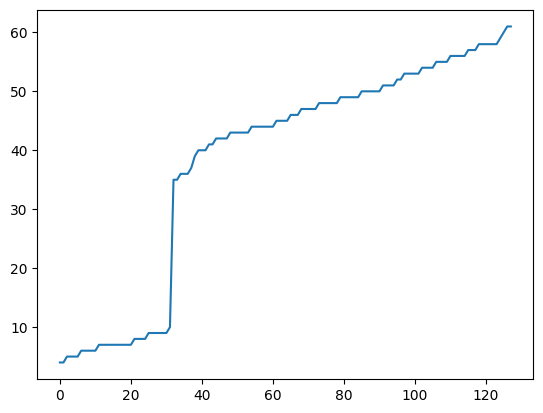

In [59]:
orthant_counts = torch.zeros(128)
for x in X_train:
    orthant_counts[find_orthant(x)] += 1
plt.plot(range(128), torch.sort(orthant_counts).values)

#### Validation data

In [67]:
X_val_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(VAL_COUNT)
    ]) for orthant in ORTHANTS
])
X_val_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(VAL_COUNT)
    ]) for orthant in ORTHANTS
])
Y_val_0 = torch.zeros(len(X_val_0), 1)
Y_val_1 = torch.ones(len(X_val_1), 1)
X_val_0.shape, X_val_1.shape, Y_val_0.shape, Y_val_1.shape

(torch.Size([512, 7]),
 torch.Size([512, 7]),
 torch.Size([512, 1]),
 torch.Size([512, 1]))

In [68]:
X_val = torch.cat([X_val_0, X_val_1])
Y_val = torch.cat([Y_val_0, Y_val_1])
X_val.shape, Y_val.shape

(torch.Size([1024, 7]), torch.Size([1024, 1]))

#### Test data

In [69]:
X_test_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(TEST_COUNT)
    ]) for orthant in ORTHANTS
])
X_test_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(TEST_COUNT)
    ]) for orthant in ORTHANTS
])
Y_test_0 = torch.zeros(len(X_test_0), 1)
Y_test_1 = torch.ones(len(X_test_1), 1)
X_test_0.shape, X_test_1.shape, Y_test_0.shape, Y_test_1.shape

(torch.Size([1280, 7]),
 torch.Size([1280, 7]),
 torch.Size([1280, 1]),
 torch.Size([1280, 1]))

In [70]:
X_test = torch.cat([X_test_0, X_test_1])
Y_test = torch.cat([Y_test_0, Y_test_1])
X_test.shape, Y_test.shape

(torch.Size([2560, 7]), torch.Size([2560, 1]))